In [8]:
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib import cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cf
import xarray
from netCDF4 import Dataset
from wrf import getvar, ALL_TIMES, interplevel, get_cartopy, to_np
from datetime import datetime

In [2]:
from goespy.Downloader import ABI_Downloader


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [ ]:
utcDateTime = dt.datetime(2018,5,23,6) 
year = utcDateTime.strftime("%Y")
month = utcDateTime.strftime("%m")
day = utcDateTime.strftime("%d")
hour = utcDateTime.strftime("%H")
##Choose a channel from your preference (can be C01-C16)
channel = ["C13"]

## In GOES satellite they have 9 products
## 3 are L1b-Rad(M,C,F)
## 3 are L2-CMIP(M,C,F)
## 3 are L2-MCMIP(M,C,F)
### In your case we will get the CMIPF, F means FullDisk (all the projection by the satellite)
product = 'ABI-L2-CMIPF'

Bucket = 'noaa-goes16'
Abi = ABI_Downloader('noaa-goes16',year,month,day,hour,product,channel)

In [5]:
wrffiles = Dataset('/home/lucas/exp/exp_01/run/wrfout_d01_2018-05-23_06:00:00')
lat = getvar(wrffiles, 'lat', timeidx=ALL_TIMES)
lon = getvar(wrffiles, 'lon', timeidx=ALL_TIMES)


ctt=getvar(wrffiles, 'ctt', timeidx=ALL_TIMES,meta=True)

p = getvar(wrffiles, 'pressure', timeidx=ALL_TIMES)
slp = getvar(wrffiles, 'slp', timeidx=ALL_TIMES)

p = getvar(wrffiles, 'pressure', timeidx=ALL_TIMES)

h = getvar(wrffiles, 'z', timeidx=ALL_TIMES)

h_500 = interplevel(h,p,500)


In [6]:
FILE = ('/home/lucas/goes16/2018/05/23/ABI-L2-CMIPF/06/C13/OR_ABI-L2-CMIPF-M3C13_G16_s20181430600435_e20181430611214_c20181430611295.nc')
C = xarray.open_dataset(FILE)

In [9]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))


Scan Start    : 2018-05-23 06:00:43.500000
Scan midpoint : 2018-05-23 06:06:02.500000
Scan End      : 2018-05-23 06:11:21.400000
File Created  : 2018-05-23 06:11:29.500000
Scan Duration : 10.62 minutes


In [10]:
CMI=C["CMI"][:]

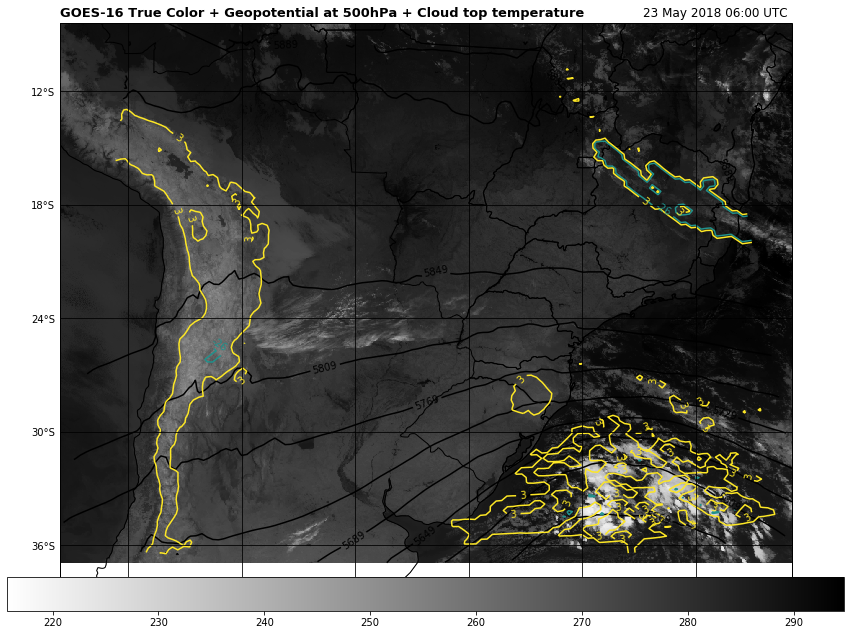

In [14]:
# We'll use the `CMI_C02` variable as a 'hook' to get the CF metadata.
datacrs = ccrs.PlateCarree()
dat = C.metpy.parse_cf('CMI')

geos = dat.metpy.cartopy_crs

# We also need the x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))


# Plot 500-hPa Geopotential Heights in meters
clevs_hgt = np.arange(h_500.min().values,\
                           h_500.max().values,40)

hgt = ax.contour(lon, lat, h_500, clevs_hgt, colors='black',
                transform=datacrs)
plt.clabel(hgt, fmt='%d')


clevs_ctt = np.arange(ctt.min().values,\
                           ctt.max().values,30)

sfc = ax.contour(lon, lat, ctt,clevs_ctt, 
                transform=datacrs)
plt.clabel(sfc, fmt='%d')

cmi = ax.imshow(CMI, origin='upper', cmap=get_cmap('gray_r'),
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)
plt.colorbar(cmi, orientation='horizontal', pad=0, aspect=25)

ax.set_extent([lon.min(),lat.min(),lon.max(),lat.max()])

# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

plt.title('GOES-16 True Color + Geopotential at 500hPa + Cloud top temperature',\
          loc='left', fontweight='bold', fontsize=13)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')
plt.savefig('./c13_h500_ctt.png')